In [115]:
import pandas as pd

# 加载数据
data_path = 'forestfires.csv'
df = pd.read_csv(data_path)

# 显示数据的前几行以及基本信息
df_info = df.info()
df_head = df.head()

Q1 = df['area'].quantile(0.25)
Q3 = df['area'].quantile(0.75)

# 计算IQR
IQR = Q3 - Q1

# 定义异常值的上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常值
df = df[(df['area'] >= lower_bound) & (df['area'] <= upper_bound)]
(df_info, df_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


(None,
    X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
 0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
 1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
 2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
 3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
 4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0)

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
import numpy as np


numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
correlation_records = []

# 对每个特征计算与'area'的皮尔逊相关系数
for feature in numeric_features[:-1]:  # 排除'area'
    correlation_coefficient, _ = pearsonr(df[feature], df['area'])
    correlation_records.append({'Variable': feature, 'CorrelationWithArea': correlation_coefficient})

# 从记录列表创建DataFrame
correlation_with_area = pd.DataFrame(correlation_records)
X = df[numeric_features].drop('area', axis=1)  
X['intercept'] = 1 


vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

(correlation_with_area, vif_data)

(  Variable  CorrelationWithArea
 0     FFMC             0.006284
 1      DMC             0.054337
 2       DC             0.048027
 3      ISI            -0.007587
 4     temp             0.003789
 5       RH             0.002315
 6     wind             0.040258
 7     rain             0.085369,
     Variable         VIF
 0       FFMC    1.663036
 1        DMC    2.379765
 2         DC    2.125557
 3        ISI    1.557359
 4       temp    2.800951
 5         RH    2.017071
 6       wind    1.119791
 7       rain    1.053207
 8  intercept  451.724247)

In [117]:
zero_area_percentage = (df['area'] == 0).mean() * 100
zero_area_percentage

54.40528634361234

In [118]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


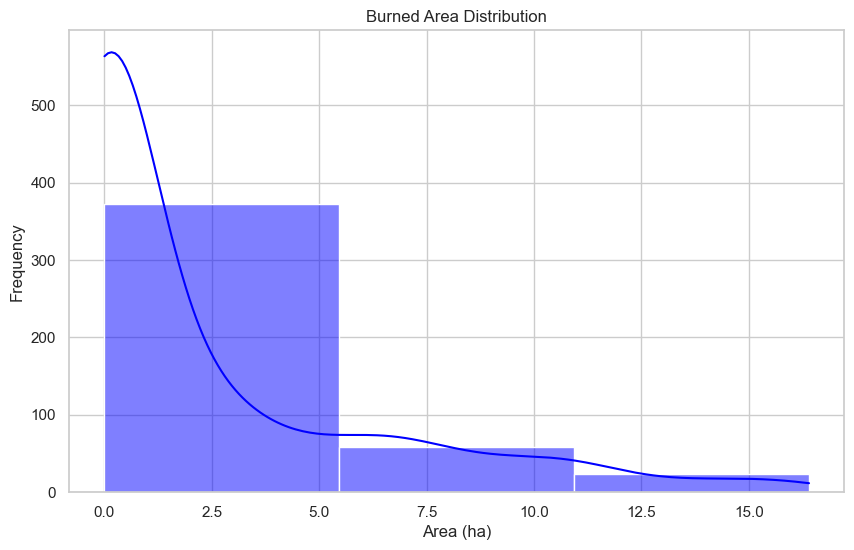

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 绘制area的分布图
plt.figure(figsize=(10, 6))
sns.histplot(df['area'], kde=True, color="blue", binwidth=5)
plt.title('Burned Area Distribution')
plt.xlabel('Area (ha)')
plt.ylabel('Frequency')
plt.show()

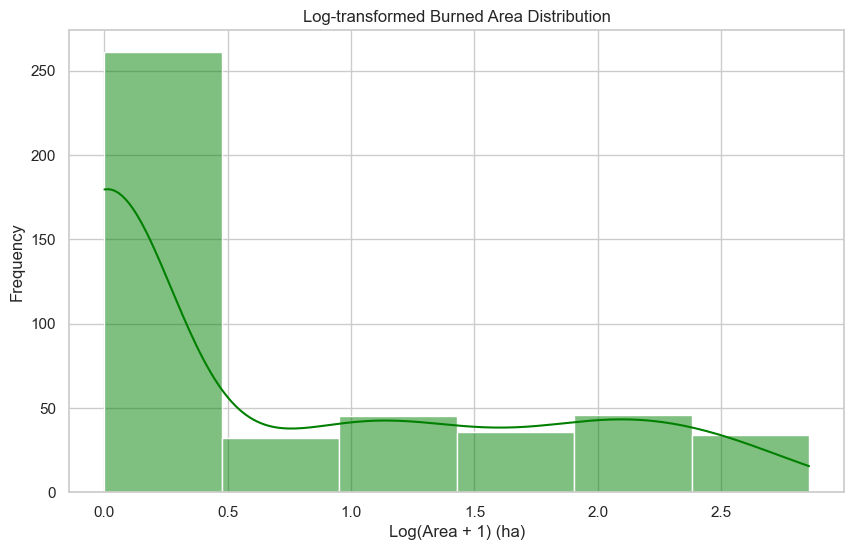

In [120]:
df['log_area'] = np.log1p(df['area'])

# 绘制对数变换后的area的分布图
plt.figure(figsize=(10, 6))
sns.histplot(df['log_area'], kde=True, color="green", binwidth=0.5)
plt.title('Log-transformed Burned Area Distribution')
plt.xlabel('Log(Area + 1) (ha)')
plt.ylabel('Frequency')
plt.show()

In [121]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 假设df是你的数据集DataFrame，并且已经定义了

# 定义自变量和因变量
X = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]  # 自变量
y = df['log_area']  # 因变量

# 向前选择的函数
def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype='float64')
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    
    return best_features

# 执行向前选择
selected_features = forward_selection(X, y)

print("Selected features:", selected_features)

Selected features: []


In [122]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 假设df是你的数据集DataFrame，并且已经定义了

# 定义自变量和因变量
X = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]  # 自变量
y = df['area']  # 因变量

# 向后选择的函数
def backward_elimination(X, y, significance_level=0.05):
    features = X.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(X[features])
        p_values = sm.OLS(y, features_with_constant).fit().pvalues[1:]  # 排除截距的p值
        max_p_value = p_values.max()  # 找到最大的p值
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# 执行向后选择
selected_features = backward_elimination(X, y)

print("Selected features:", selected_features)
# 使用向后选择的结果来拟合最终模型
final_features = sm.add_constant(X[selected_features])  # 添加常数项
final_model = sm.OLS(y, final_features).fit()  # 拟合模型

# 获取系数和截距
intercept = final_model.params[0]  # 截距
coefficients = final_model.params[1:]  # 系数

# 打印截距和系数
print(f'Intercept: {intercept}')
print('Coefficients:')
print(coefficients)

Selected features: []
Intercept: 2.3317841409691633
Coefficients:
Series([], dtype: float64)


In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# 由于选择的特征只有temp，我们用它来生成预测值
df['predicted_area'] = intercept + coefficients['temp'] * df['temp'] + coefficients['RH'] * df['RH']
sorted_df = df.sort_values(by='temp')
# 计算MSE和R²
mse = mean_squared_error(np.exp(df['area']) - 1, df['predicted_area'])
r2 = r2_score(np.exp(df['area']) - 1, df['predicted_area'])

print(f'MSE: {mse}')
print(f'R²: {r2}')

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.scatter(df['temp'], np.exp(df['log_area']) - 1, color='blue', label='Actual Area', alpha=0.5)
plt.plot(sorted_df['temp'], df['predicted_area'], color='red', label='Predicted Area', linewidth=2)
plt.xlabel('Temperature')
plt.ylabel('Area')
plt.title('Actual vs. Predicted Area by Temperature')
plt.legend()
plt.show()

KeyError: 'temp'

MSE: 0.8584838503902089
R²: -0.0025913182520733713


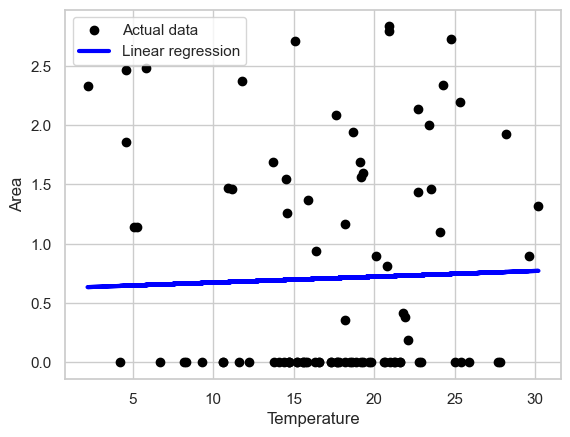

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 假设df是你的DataFrame，并且已经包含了temp和area两列

# 准备数据
X = df[['temp']]  # 解释变量
y = df['log_area']  # 响应变量

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建立线性回归模型
model = LinearRegression()

# 训练模型
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')

# 绘制回归线
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Linear regression')
plt.xlabel('Temperature')
plt.ylabel('Area')
plt.legend()
plt.show()